# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data Aquisition](#data)
* [3. Methodology](#methodology)
* [4. Results and Discussion](#results)
* [5. Conclusion](#conclusion)

<h2>1. Introduction: Business Problem</h2>

<p>Toronto is the capital city of the Canadian province of Ontario, which is an international center of business, finance, and cultures. It is home to the Toronto Stock Exchange and the headquarters of the five largest Canadian banks. Toronto is also the center of music, television production, cultural festivals and events. As one of the most popular tourism destination, visitors and residents will always have a variety of things to do on their list, from the famous CN Tower featuring cosmopolitian city life to the impresive Niagara Falls within an accessible distance.</p>

<p>Toronto is ranked as the 16th in the 2018 Mercer Quality of Living survey. The rannking is based on a combination of several factors, such as economic strength, cultural interaction, research and development. However, from my personal experience, the list may not be an accurate description of the city. Large city has many neighborhoods and not all neighborhoods live up to the score of the survey. For example, New York is ranked as 4th Best City to live in according to Global Finance Magazine but Vinegar Hill is definitely not a safe neighborhood to stay.</p>

<p>Therefore, this capstone project aims to provide readers with a more detailed comparason among different neighborhoods in Toronto based on various perspectives: crime rate, restaurants, and Covid 19 cases. It is important to note that the Covid 19 situation is included in the analysis as this rare pandemic in some ways can reflect the productivity of the medical systems and the efficiency of the local governments.</p>

<h2>2. Data Aquisition</h2>

<p>The match between post code and different neighborhoods are scraped down from <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">Wikipedia</a>. In addition to the wikipedia table, the exact geographical location of each neighborhoods can be found in <a href="http://cocl.us/Geospatial_data">Geospacial Data</a>.</p>

<p>The information of Food and Beverage can found on FourSquare, which is a location data platform. FourSquare is a masstive location data network that offers venue details in 30+ attribute fields and 900+ venue categories in 190+ countris and 50+ categories.</p>

<p>The details of crime rate and Covid 19 cases are downloaded from Kaggle which is a online community for data scientist and machine learning practitioners to find and publish data sets. Toronto Crime Rate Per Neighborhood can be obtained <a href="https://www.kaggle.com/alincijov/toronto-crime-rate-per-neighbourhood">here</a>. Lastly, <a href="https://www.kaggle.com/divyansh22/toronto-covid19-cases">this</a> is where the Toronto Covid 19 Cases is from.</p>

<h3>2.1 Data Source</h3>

In [32]:
from pathlib import Path
!pip install lxml
!pip install bs4
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import requests
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install geopandas
!pip install geopy
from geopy.geocoders import Nominatim

print("Library imported")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Library imported


In [113]:
#scraper the wikipedia table
wikiurl="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

#parse data from the html
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})
df=pd.read_html(str(indiatable))

# convert list to dataframe
df=pd.DataFrame(df[0])
df.head()

200


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [114]:
#upload geographical coordinate
Toronto = pd.read_csv("Geospatial_Coordinates.csv")
Toronto.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [115]:
#upload covid-19 cases 
covid_19 = pd.read_csv('COVID19 cases Toronto.csv')
covid_19.head()

,_id,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,44294,Sporadic,50-59,Malvern,M1B,Institutional,CONFIRMED,2020-03-25,2020-03-27,MALE,RESOLVED,No,No,No,No,No,No
1,44295,Sporadic,20-29,Malvern,M1B,Community,CONFIRMED,2020-03-20,2020-03-28,MALE,RESOLVED,No,No,No,Yes,No,No
2,44296,Sporadic,60-69,Malvern,M1B,Travel,CONFIRMED,2020-03-04,2020-03-08,FEMALE,RESOLVED,No,No,No,Yes,Yes,Yes
3,44297,Outbreak Associated,50-59,Rouge,M1B,N/A - Outbreak associated,CONFIRMED,2020-05-02,2020-05-04,FEMALE,RESOLVED,No,No,No,No,No,No
4,44298,Sporadic,30-39,Rouge,M1B,Close contact,CONFIRMED,2020-05-31,2020-06-06,FEMALE,RESOLVED,No,No,No,No,No,No


In [116]:
#upload neighborhood crime rate
crime_rate = pd.read_csv('Neighbourhood_Crime_Rates_(Boundary_File)_.csv')
crime_rate.head()

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,...,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,...,5,8,0,3,6,4.3,1.00,47.9,1.161315e+06,5873.270582
1,2,York University Heights,27,27593,271,296,361,344,357,370,...,46,37,39,38,28,36.3,-0.26,101.5,1.324666e+07,18504.777326
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,...,5,5,11,6,11,7.0,0.83,68.1,5.346186e+06,11112.109625
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,...,14,26,23,20,29,22.5,0.45,195.9,6.038326e+06,10079.426920
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,...,8,4,6,7,4,6.0,-0.43,16.0,7.946202e+06,11853.189878


<h3>2.2 Data Cleaning</h3>

<p>Since some data on the wikipedia is not assigned, it is necessary to get rid of the invalid data and repetitive values. </p>

In [117]:
#delete Non assgined rows 
df = df[df['Borough'] != 'Not assigned']
df.head()


#Replace Not assigned in the neighborhood with borough values
Neighbourhood = df[df['Neighbourhood'] == 'Not assigned']
Neighbourhood.head()
#(checked that there is no neighbourhood that has the values of "Not assigned")

,Postal Code,Borough,Neighbourhood


<p>Combine the geographical coordinates with the neighborhood information.</p>

In [118]:
#combine the geographical coordinates with the neighborhood informtion
df.reset_index(inplace=True)
Table = df.merge(Toronto,how='outer', on='Postal Code')
Table.head()

,index,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,2,M3A,North York,Parkwoods,43.753259,-79.329656
1,3,M4A,North York,Victoria Village,43.725882,-79.315572
2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


<h2>3. Methodology</h2>

<h3>3.1 Covid-19 Case Analysis</h3>

In [119]:
# only save cases that are still active
covid_19= covid_19[covid_19['Outcome'] != 'RESOLVED']
covid_19 = covid_19.set_index(["FSA","Outcome"]).count(level="FSA")
covid_19 = covid_19.rename(columns = {"_id":"Total"})

In [120]:
#sort the cases in a descending order
covid_19_Mostcase = covid_19.sort_values(by='Total', ascending=False)
covid_19_Mostcase.head(10)

,Total,Outbreak Associated,Age Group,Neighbourhood Name,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
FSA,,,,,,,,,,,,,,,
M1E,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94
M3J,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71
M6M,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68
M9V,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62
M9B,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61
M1C,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60
M6B,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57
M1N,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
M9P,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48


In [121]:
#sort the cases in an ascending order
covid_19_Few_Case = covid_19.sort_values(by='Total', ascending=True)
covid_19_Few_Case.head(10)

,Total,Outbreak Associated,Age Group,Neighbourhood Name,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
FSA,,,,,,,,,,,,,,,
M4T,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
M3K,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
M4G,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
M1S,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
M3B,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
M5B,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
M2P,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
M5E,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
M8Z,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


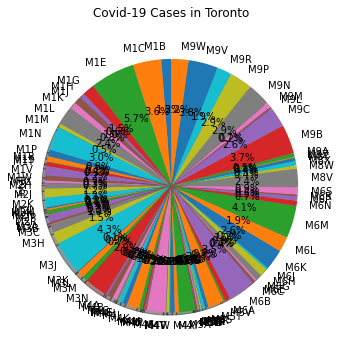

In [122]:
#visualization of the covid-19 situation 
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

# autopct create %, start angle represent starting point
covid_19['Total'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                            )

plt.title('Covid-19 Cases in Toronto')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

<h3>3.2 Crime Rate Analysis</h3>

In [123]:
#Select the average of the crime number of different crime types
crime_rate = crime_rate[["Neighbourhood","Population","Assault_AVG","AutoTheft_AVG","BreakandEnter_AVG","Homicide_AVG","Robbery_AVG","TheftOver_AVG"]]
crime_rate.head()

,Neighbourhood,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG
0,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3
1,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3
2,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0
3,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5
4,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0


In [124]:
#sum up the total crime number
sum_column = crime_rate["Assault_AVG"]+crime_rate["AutoTheft_AVG"]+ crime_rate["BreakandEnter_AVG"]+ crime_rate["Homicide_AVG"]+crime_rate["Robbery_AVG"]+crime_rate["TheftOver_AVG"]
crime_rate["Total"] = sum_column
crime_rate.head()

,Neighbourhood,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Total
0,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3,68.6
1,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3,665.6
2,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0,156.6
3,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5,334.2
4,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0,191.4


In [125]:
#determine the crime rate per 1000 people in each neighborhood
rate = crime_rate["Total"]/crime_rate["Population"]*1000
crime_rate["Average"] = rate
crime_rate.head()

,Neighbourhood,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Total,Average
0,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3,68.6,5.475734
1,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3,665.6,24.122060
2,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0,156.6,9.688196
3,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5,334.2,22.574980
4,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0,191.4,7.640414


In [126]:
#Sort out the top 10 safest area in Toronto
crime_rate = crime_rate.sort_values(by = 'Average', ascending=True)
crime_rate.head(10)

,Neighbourhood,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Total,Average
100,Mount Pleasant East,16775,34.7,9.8,29.7,0.0,7.2,3.5,84.9,5.061103
126,Steeles,24623,39.3,25.0,56.7,0.0,9.7,3.7,134.4,5.458311
0,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3,68.6,5.475734
138,Leaside-Bennington,16828,32.8,18.2,33.3,0.2,7.5,5.2,97.2,5.776087
127,Lawrence Park North,14607,27.7,23.3,26.5,0.2,3.8,4.2,85.7,5.867050
136,Pleasant View,15818,46.0,13.5,19.8,0.2,11.8,3.8,95.1,6.012138
95,Willowdale East,50434,145.7,36.2,83.2,0.0,37.7,14.7,317.5,6.295356
21,Centennial Scarborough,13362,46.5,9.5,19.2,0.3,7.5,2.0,85.0,6.361323
9,Danforth East York,17180,65.8,9.3,27.2,0.0,5.8,2.8,110.9,6.455180
125,Markland Wood,10554,20.7,12.3,25.8,0.0,7.8,2.2,68.8,6.518855


<h3>3.3 Food and Beverage Analysis</h3>

In [127]:
CLIENT_ID = 'SM0XORTGFJMH3BMPDKQDC15CEEUF42RZXXWP4B33ICCEVQM0' # your Foursquare ID
CLIENT_SECRET = 'R00GTG4DZXEZPMEHZVIDH1RFDYG1TSXUKMLDTOP15WDJ1CQH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SM0XORTGFJMH3BMPDKQDC15CEEUF42RZXXWP4B33ICCEVQM0
CLIENT_SECRET:R00GTG4DZXEZPMEHZVIDH1RFDYG1TSXUKMLDTOP15WDJ1CQH


In [128]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [130]:
venues = getNearbyVenues(names=Table['Neighbourhood'],
                                   latitudes=Table['Latitude'],
                                   longitudes=Table['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [132]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighbourhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
onehot = onehot.groupby('Neighbourhood').mean().reset_index()
onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
food = onehot[["Neighbourhood","Restaurant"]]
food.head()

,Neighbourhood,Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.045455


In [141]:
food = food.sort_values(by='Restaurant', ascending = False)
food.head()

,Neighbourhood,Restaurant
21,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",0.200000
34,"Guildwood, Morningside, West Hill",0.125000
59,"Parkdale, Roncesvalles",0.071429
53,"New Toronto, Mimico South, Humber Bay Shores",0.071429
77,"Summerhill West, Rathnelly, South Hill, Forest...",0.071429
